#### Human activity classification with convolutional encoder feature representations

The model architecture and feature engineering methods from the following paper are implemented

[On the Role of Features in HAR](https://dl.acm.org/doi/10.1145/3341163.3347727)

Classification: probabilistic classification with MLP

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import json
import sys

import torch
import torch.nn.functional as F

import skopt
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt import callbacks
from skopt.callbacks import CheckpointSaver

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sys.executable

'c:\\Users\\arthu\\AppData\\Local\\Programs\\Python\\Python311\\python.exe'

In [3]:

module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)
    
from enc_class_training_loop import train_and_save_conv_classifier
from frame_dataloader_heavy import WorkloadFrame
import utils

# if there is trouble installing modules: compare python paths used in notebooks vs cmd
# print(sys.executable)
# !python -c "import sys; print(sys.executable)"

# install modules to the currently used python path in cmd
#%pip install scikit-optimize
# OR
#"C:\path\to\your\jupyter\python.exe" -m pip install scikit-optimize

# check what env jupyter is using, install the correct one
# jupyter kernelspec list
# python -m ipykernel install --user --name myenv --display-name "Python (myenv)"

# saving project requirements:
# pip freeze > requirements.txt
# pip install -r requirements.txt



#### Probing 1
evaluating classification output

In [43]:
target = F.one_hot(torch.randint(0, 4, (64, )), num_classes=4)
target.shape

torch.Size([64, 4])

In [42]:
classification = F.softmax(torch.randn((64, 4)), dim=1)
classification.shape

torch.Size([64, 4])

In [41]:
torch.sum(torch.argmax(classification, dim=1) == torch.argmax(target, dim=1))

tensor(19)

#### Probing

Early stopping and learning rate heuristics

In [4]:
a = F.one_hot(torch.tensor(3), 5)
b = F.one_hot(torch.tensor(1), 5)
a, b

(tensor([0, 0, 0, 1, 0]), tensor([0, 1, 0, 0, 0]))

In [5]:
torch.argmax(a)

tensor(3)

In [6]:
s = pd.Series([1, 2, 3, 4, 5, 6,7])
x = s[-12:].values**2
y = np.arange(len(x))
grad = np.gradient(y, x)

grad

array([0.33333333, 0.28333333, 0.17619048, 0.12896825, 0.1020202 ,
       0.08449883, 0.07692308])

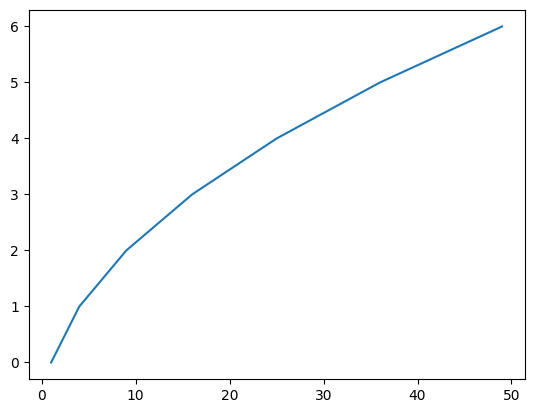

In [7]:
plt.plot(x, y)

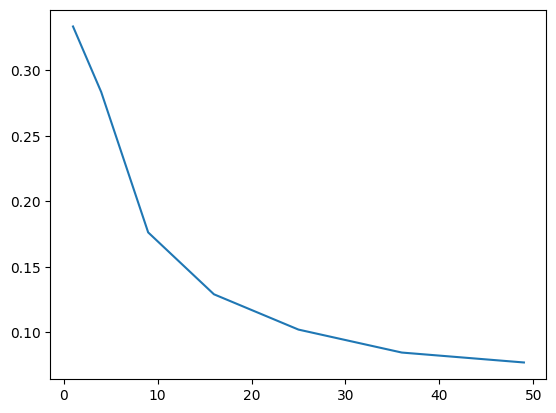

In [8]:
plt.plot(x, grad)

#### Bayesian Parameter Optimization

Finds objective Loss function of model hyperparameters 

- randomly samples parameter space via initial_point_generator for n_initialial_points
- observes function values and approximates function with gaussian prior
- updates prior based on observed values

The optimization result returned as a OptimizeResult object. Saved attributes are:
```
x [list]: location of the minimum.

fun [float]: function value at the minimum.

x_iters [list of lists]: location of function evaluation for each iteration.

func_vals [array]: function value for each iteration.

space [Space]: the optimization space

specs [dict]`: the call specifications.

rng [RandomState instance]: State of the random state at the end of minimization.
```
For more details related to the OptimizeResult object, see [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html)

for more, see [Documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize)

#### Training log:


$BayesOpt2Error$ minimized % classification error with the 'phys' group labels but provided poor results due to bug in model evaluation

$BayesOpt3ErrorPhys$ runs across all hyperparameters except # conv blocks, minimizing % classification error whilst using the 'phys' group labels. Failed due to overfitting

$BayesOpt4ErrorPhys$ runs across hidden and latent dim, minimizing % classification error. Uses (10, 2) convolution kernel, with 2 convolution blocks starting at 4 channels

In [5]:
param_space = [
    Integer(16,  156, name='hidden_dim'), # hidden layer dimension
    Integer(16, 156, name='latent_dim'), # latent dimension
    #Integer(4, 8, name='init_channel'), # initial channel size 
    #Integer(1, 4, name='kernel_height'),
    #Integer(1, 4, name='kernel_width'),
    #Integer(1, 4, name='conv_blocks'), # number of convolutional blocks
]

# trainig epochs must stay same if optim run is interrupted to prevent skewing of loss landscape
optim_name = 'BayesOpt4CustomArch'
save_filepath = "..\\saved_models\\classifier\\bayes_opt4\\"
training_epochs = 60


file_dir='..\\files'
#  file group: 'phys', 'cog', or 'tot'
group='phys'
# signal channel to resample to: 'temp', 'hrv, 'hr', 'hbo', 'eda'
resample='temp'
# size of sliding window relative to shortest signal length; always 50% overlap between windows
context_length=0.5
frames = WorkloadFrame(dir=file_dir, group=group, resample=resample, context_length=context_length)

checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

def objective_error(x):
    hdim, ldim = x
    hdim, ldim = int(hdim), int(ldim)
    print(f'Evaluation point: \n hdim {hdim} ldim {ldim}')

    config = {'latent_dim':ldim, 'conv_blocks':[1, 4, 8], 'hidden_dim':hdim, 'kernel':(10, 2), 'id':optim_name}
    try:
        accuracy = train_and_save_conv_classifier(config=config, num_epochs=training_epochs, save_filepath=save_filepath, dataset=frames)
    except Exception as e:
        print(f'Trianing failed {e}')
    error = 1-accuracy
    print(f'Achieved final error of {error}')
    return error

In [6]:
result = gp_minimize(
    objective_error, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=150, # total function calls
    n_initial_points=50, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)

Iteration No: 1 started. Evaluating function at random point.
Evaluation point: 
 hdim 48 ldim 61
Using 4 workers (CPU cores: 8, Available RAM: 3.32GB)


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4172065258026123
No saved weights found for conv_classifier_ldim61_convblocks3_hdim48_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim61_convblocks3_hdim48_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim61_convblocks3_hdim48_kernel(10, 2)_idBayesOpt4CustomArch')


Model trained for 59 epochs. Saved data for conv_classifier_ldim61_convblocks3_hdim48_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 60.0031
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Evaluation point: 
 hdim 153 ldim 80
Using 4 workers (CPU cores: 8, Available RAM: 3.01GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.449981927871704
No saved weights found for conv_classifier_ldim80_convblocks3_hdim153_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim80_convblocks3_hdim153_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim80_convblocks

Model trained for 59 epochs. Saved data for conv_classifier_ldim80_convblocks3_hdim153_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 55.6413
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 3 started. Evaluating function at random point.
Evaluation point: 
 hdim 59 ldim 53
Using 4 workers (CPU cores: 8, Available RAM: 4.07GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4402954578399658
No saved weights found for conv_classifier_ldim53_convblocks3_hdim59_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim53_convblocks3_hdim59_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim53_convblocks3

Model trained for 59 epochs. Saved data for conv_classifier_ldim53_convblocks3_hdim59_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 58.8204
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 4 started. Evaluating function at random point.
Evaluation point: 
 hdim 28 ldim 75
Using 4 workers (CPU cores: 8, Available RAM: 2.96GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.40863037109375
No saved weights found for conv_classifier_ldim75_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim75_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim75_convblocks3_hd

Model trained for 59 epochs. Saved data for conv_classifier_ldim75_convblocks3_hdim28_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 56.9782
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 5 started. Evaluating function at random point.
Evaluation point: 
 hdim 18 ldim 90
Using 4 workers (CPU cores: 8, Available RAM: 3.80GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4463268518447876
No saved weights found for conv_classifier_ldim90_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim90_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim90_convblocks3_

Model trained for 59 epochs. Saved data for conv_classifier_ldim90_convblocks3_hdim18_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 63.7839
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 6 started. Evaluating function at random point.
Evaluation point: 
 hdim 138 ldim 62
Using 4 workers (CPU cores: 8, Available RAM: 3.44GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4108779430389404
No saved weights found for conv_classifier_ldim62_convblocks3_hdim138_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim62_convblocks3_hdim138_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim62_convblock

Model trained for 59 epochs. Saved data for conv_classifier_ldim62_convblocks3_hdim138_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 65.9783
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 7 started. Evaluating function at random point.
Evaluation point: 
 hdim 71 ldim 110
Using 4 workers (CPU cores: 8, Available RAM: 3.55GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4379955530166626
No saved weights found for conv_classifier_ldim110_convblocks3_hdim71_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim110_convblocks3_hdim71_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim110_convblo

Model trained for 59 epochs. Saved data for conv_classifier_ldim110_convblocks3_hdim71_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 71.2385
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 8 started. Evaluating function at random point.
Evaluation point: 
 hdim 110 ldim 113
Using 4 workers (CPU cores: 8, Available RAM: 3.19GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3792206048965454
No saved weights found for conv_classifier_ldim113_convblocks3_hdim110_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim113_convblocks3_hdim110_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim113_conv

Model trained for 59 epochs. Saved data for conv_classifier_ldim113_convblocks3_hdim110_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 64.4342
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 9 started. Evaluating function at random point.
Evaluation point: 
 hdim 64 ldim 146
Using 4 workers (CPU cores: 8, Available RAM: 3.55GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3785302639007568
No saved weights found for conv_classifier_ldim146_convblocks3_hdim64_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim146_convblocks3_hdim64_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim146_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim146_convblocks3_hdim64_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 60.7542
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 10 started. Evaluating function at random point.
Evaluation point: 
 hdim 53 ldim 121
Using 4 workers (CPU cores: 8, Available RAM: 4.04GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4533015489578247
No saved weights found for conv_classifier_ldim121_convblocks3_hdim53_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim121_convblocks3_hdim53_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim121_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim121_convblocks3_hdim53_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 61.3628
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 11 started. Evaluating function at random point.
Evaluation point: 
 hdim 52 ldim 135
Using 4 workers (CPU cores: 8, Available RAM: 3.96GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.361946940422058
No saved weights found for conv_classifier_ldim135_convblocks3_hdim52_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim135_convblocks3_hdim52_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim135_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim135_convblocks3_hdim52_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 60.4213
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 12 started. Evaluating function at random point.
Evaluation point: 
 hdim 40 ldim 127
Using 4 workers (CPU cores: 8, Available RAM: 4.42GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3884729146957397
No saved weights found for conv_classifier_ldim127_convblocks3_hdim40_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim127_convblocks3_hdim40_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim127_convb

Model trained for 59 epochs. Saved data for conv_classifier_ldim127_convblocks3_hdim40_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 63.4872
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 13 started. Evaluating function at random point.
Evaluation point: 
 hdim 147 ldim 79
Using 4 workers (CPU cores: 8, Available RAM: 2.87GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.442994475364685
No saved weights found for conv_classifier_ldim79_convblocks3_hdim147_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim79_convblocks3_hdim147_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim79_convblo

Model trained for 59 epochs. Saved data for conv_classifier_ldim79_convblocks3_hdim147_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 60.4642
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 14 started. Evaluating function at random point.
Evaluation point: 
 hdim 70 ldim 66
Using 4 workers (CPU cores: 8, Available RAM: 4.00GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.496319055557251
No saved weights found for conv_classifier_ldim66_convblocks3_hdim70_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim66_convblocks3_hdim70_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim66_convblocks

Model trained for 59 epochs. Saved data for conv_classifier_ldim66_convblocks3_hdim70_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 65.7581
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 15 started. Evaluating function at random point.
Evaluation point: 
 hdim 43 ldim 30
Using 4 workers (CPU cores: 8, Available RAM: 2.76GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4542832374572754
No saved weights found for conv_classifier_ldim30_convblocks3_hdim43_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim30_convblocks3_hdim43_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim30_convblocks

Model trained for 59 epochs. Saved data for conv_classifier_ldim30_convblocks3_hdim43_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 61.2493
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 16 started. Evaluating function at random point.
Evaluation point: 
 hdim 84 ldim 102
Using 4 workers (CPU cores: 8, Available RAM: 3.87GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.447688341140747
No saved weights found for conv_classifier_ldim102_convblocks3_hdim84_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim102_convblocks3_hdim84_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim102_convblo

Model trained for 59 epochs. Saved data for conv_classifier_ldim102_convblocks3_hdim84_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 62.8600
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 17 started. Evaluating function at random point.
Evaluation point: 
 hdim 149 ldim 65
Using 4 workers (CPU cores: 8, Available RAM: 4.00GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.417722225189209
No saved weights found for conv_classifier_ldim65_convblocks3_hdim149_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim65_convblocks3_hdim149_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim65_convblo

Model trained for 59 epochs. Saved data for conv_classifier_ldim65_convblocks3_hdim149_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 63.3481
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 18 started. Evaluating function at random point.
Evaluation point: 
 hdim 55 ldim 79
Using 4 workers (CPU cores: 8, Available RAM: 4.04GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3739018440246582
No saved weights found for conv_classifier_ldim79_convblocks3_hdim55_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim79_convblocks3_hdim55_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim79_convblock

Model trained for 59 epochs. Saved data for conv_classifier_ldim79_convblocks3_hdim55_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 61.7346
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 19 started. Evaluating function at random point.
Evaluation point: 
 hdim 150 ldim 41
Using 4 workers (CPU cores: 8, Available RAM: 4.08GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4260213375091553
No saved weights found for conv_classifier_ldim41_convblocks3_hdim150_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim41_convblocks3_hdim150_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim41_convblo

Model trained for 59 epochs. Saved data for conv_classifier_ldim41_convblocks3_hdim150_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 60.7426
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 20 started. Evaluating function at random point.
Evaluation point: 
 hdim 36 ldim 28
Using 4 workers (CPU cores: 8, Available RAM: 4.13GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3828959465026855
No saved weights found for conv_classifier_ldim28_convblocks3_hdim36_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim28_convblocks3_hdim36_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim28_convblock

Model trained for 59 epochs. Saved data for conv_classifier_ldim28_convblocks3_hdim36_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 58.8607
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 21 started. Evaluating function at random point.
Evaluation point: 
 hdim 93 ldim 59
Using 4 workers (CPU cores: 8, Available RAM: 3.88GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5334935188293457
No saved weights found for conv_classifier_ldim59_convblocks3_hdim93_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim59_convblocks3_hdim93_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim59_convblocks

Model trained for 59 epochs. Saved data for conv_classifier_ldim59_convblocks3_hdim93_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 57.7465
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 22 started. Evaluating function at random point.
Evaluation point: 
 hdim 56 ldim 145
Using 4 workers (CPU cores: 8, Available RAM: 4.18GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3702460527420044
No saved weights found for conv_classifier_ldim145_convblocks3_hdim56_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim145_convblocks3_hdim56_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim145_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim145_convblocks3_hdim56_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 56.7697
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 23 started. Evaluating function at random point.
Evaluation point: 
 hdim 77 ldim 75
Using 4 workers (CPU cores: 8, Available RAM: 3.98GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4642360210418701
No saved weights found for conv_classifier_ldim75_convblocks3_hdim77_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim75_convblocks3_hdim77_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim75_convblock

Model trained for 59 epochs. Saved data for conv_classifier_ldim75_convblocks3_hdim77_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 56.4386
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 24 started. Evaluating function at random point.
Evaluation point: 
 hdim 154 ldim 127
Using 4 workers (CPU cores: 8, Available RAM: 3.79GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5311987400054932
No saved weights found for conv_classifier_ldim127_convblocks3_hdim154_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim127_convblocks3_hdim154_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim127_con

Model trained for 59 epochs. Saved data for conv_classifier_ldim127_convblocks3_hdim154_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 58.1368
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 25 started. Evaluating function at random point.
Evaluation point: 
 hdim 64 ldim 58
Using 4 workers (CPU cores: 8, Available RAM: 3.97GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.395632266998291
No saved weights found for conv_classifier_ldim58_convblocks3_hdim64_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim58_convblocks3_hdim64_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim58_convblock

Model trained for 59 epochs. Saved data for conv_classifier_ldim58_convblocks3_hdim64_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 64.5457
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 26 started. Evaluating function at random point.
Evaluation point: 
 hdim 87 ldim 103
Using 4 workers (CPU cores: 8, Available RAM: 3.08GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.410543441772461
No saved weights found for conv_classifier_ldim103_convblocks3_hdim87_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim103_convblocks3_hdim87_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim103_convblo

Model trained for 59 epochs. Saved data for conv_classifier_ldim103_convblocks3_hdim87_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 65.6796
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 27 started. Evaluating function at random point.
Evaluation point: 
 hdim 108 ldim 52
Using 4 workers (CPU cores: 8, Available RAM: 3.06GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.5657098293304443
No saved weights found for conv_classifier_ldim52_convblocks3_hdim108_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim52_convblocks3_hdim108_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim52_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim52_convblocks3_hdim108_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 67.2027
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 28 started. Evaluating function at random point.
Evaluation point: 
 hdim 73 ldim 109
Using 4 workers (CPU cores: 8, Available RAM: 2.81GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.361470341682434
No saved weights found for conv_classifier_ldim109_convblocks3_hdim73_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim109_convblocks3_hdim73_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim109_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim109_convblocks3_hdim73_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 62.2531
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 29 started. Evaluating function at random point.
Evaluation point: 
 hdim 78 ldim 125
Using 4 workers (CPU cores: 8, Available RAM: 3.18GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4321401119232178
No saved weights found for conv_classifier_ldim125_convblocks3_hdim78_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim125_convblocks3_hdim78_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim125_convb

Model trained for 59 epochs. Saved data for conv_classifier_ldim125_convblocks3_hdim78_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 67.7448
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 30 started. Evaluating function at random point.
Evaluation point: 
 hdim 112 ldim 119
Using 4 workers (CPU cores: 8, Available RAM: 3.46GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4908220767974854
No saved weights found for conv_classifier_ldim119_convblocks3_hdim112_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim119_convblocks3_hdim112_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim119_co

Model trained for 59 epochs. Saved data for conv_classifier_ldim119_convblocks3_hdim112_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 60.3921
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 31 started. Evaluating function at random point.
Evaluation point: 
 hdim 85 ldim 150
Using 4 workers (CPU cores: 8, Available RAM: 3.15GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4702932834625244
No saved weights found for conv_classifier_ldim150_convblocks3_hdim85_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim150_convblocks3_hdim85_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim150_conv

Model trained for 59 epochs. Saved data for conv_classifier_ldim150_convblocks3_hdim85_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 61.2395
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 32 started. Evaluating function at random point.
Evaluation point: 
 hdim 38 ldim 107
Using 4 workers (CPU cores: 8, Available RAM: 2.64GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3631784915924072
No saved weights found for conv_classifier_ldim107_convblocks3_hdim38_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim107_convblocks3_hdim38_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim107_convb

Model trained for 59 epochs. Saved data for conv_classifier_ldim107_convblocks3_hdim38_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 60.3011
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 33 started. Evaluating function at random point.
Evaluation point: 
 hdim 94 ldim 138
Using 4 workers (CPU cores: 8, Available RAM: 3.45GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.476388931274414
No saved weights found for conv_classifier_ldim138_convblocks3_hdim94_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim138_convblocks3_hdim94_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim138_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim138_convblocks3_hdim94_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 62.5227
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 34 started. Evaluating function at random point.
Evaluation point: 
 hdim 36 ldim 79
Using 4 workers (CPU cores: 8, Available RAM: 2.99GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.424845576286316
No saved weights found for conv_classifier_ldim79_convblocks3_hdim36_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim79_convblocks3_hdim36_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim79_convblocks

Model trained for 59 epochs. Saved data for conv_classifier_ldim79_convblocks3_hdim36_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 34 ended. Evaluation done at random point.
Time taken: 62.1313
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 35 started. Evaluating function at random point.
Evaluation point: 
 hdim 108 ldim 109
Using 4 workers (CPU cores: 8, Available RAM: 3.16GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4441304206848145
No saved weights found for conv_classifier_ldim109_convblocks3_hdim108_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim109_convblocks3_hdim108_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim109_con

Model trained for 59 epochs. Saved data for conv_classifier_ldim109_convblocks3_hdim108_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 59.8615
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 36 started. Evaluating function at random point.
Evaluation point: 
 hdim 133 ldim 91
Using 4 workers (CPU cores: 8, Available RAM: 3.33GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4169995784759521
No saved weights found for conv_classifier_ldim91_convblocks3_hdim133_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim91_convblocks3_hdim133_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim91_convb

Model trained for 59 epochs. Saved data for conv_classifier_ldim91_convblocks3_hdim133_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 59.4995
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 37 started. Evaluating function at random point.
Evaluation point: 
 hdim 22 ldim 29
Using 4 workers (CPU cores: 8, Available RAM: 3.39GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4329054355621338
No saved weights found for conv_classifier_ldim29_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim29_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim29_convblock

Model trained for 59 epochs. Saved data for conv_classifier_ldim29_convblocks3_hdim22_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 58.0809
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 38 started. Evaluating function at random point.
Evaluation point: 
 hdim 128 ldim 72
Using 4 workers (CPU cores: 8, Available RAM: 3.63GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4287010431289673
No saved weights found for conv_classifier_ldim72_convblocks3_hdim128_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim72_convblocks3_hdim128_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim72_convblo

Model trained for 59 epochs. Saved data for conv_classifier_ldim72_convblocks3_hdim128_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 58.7316
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 39 started. Evaluating function at random point.
Evaluation point: 
 hdim 112 ldim 86
Using 4 workers (CPU cores: 8, Available RAM: 3.99GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4543262720108032
No saved weights found for conv_classifier_ldim86_convblocks3_hdim112_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim86_convblocks3_hdim112_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim86_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim86_convblocks3_hdim112_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 56.4721
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 40 started. Evaluating function at random point.
Evaluation point: 
 hdim 72 ldim 126
Using 4 workers (CPU cores: 8, Available RAM: 3.76GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.424773097038269
No saved weights found for conv_classifier_ldim126_convblocks3_hdim72_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim126_convblocks3_hdim72_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim126_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim126_convblocks3_hdim72_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 60.8726
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 41 started. Evaluating function at random point.
Evaluation point: 
 hdim 149 ldim 52
Using 4 workers (CPU cores: 8, Available RAM: 3.34GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4484195709228516
No saved weights found for conv_classifier_ldim52_convblocks3_hdim149_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim52_convblocks3_hdim149_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim52_convbl

Model trained for 59 epochs. Saved data for conv_classifier_ldim52_convblocks3_hdim149_kernel(10, 2)_idBayesOpt4CustomArch
Achieved final error of 1.0
Iteration No: 41 ended. Evaluation done at random point.
Time taken: 73.4509
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 42 started. Evaluating function at random point.
Evaluation point: 
 hdim 89 ldim 138
Using 4 workers (CPU cores: 8, Available RAM: 3.39GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4699620008468628
No saved weights found for conv_classifier_ldim138_convblocks3_hdim89_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\
No existing log data found for conv_classifier_ldim138_convblocks3_hdim89_kernel(10, 2)_idBayesOpt4CustomArch in ..\saved_models\classifier\bayes_opt4\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt4\\', 'conv_classifier_ldim138_convb

KeyboardInterrupt: 

In [6]:
# results
res = skopt.load(save_filepath+optim_name+'.pkl')
print(f'Hyperparameter space [hdim, ldim, init]: \n {res.space}')
print(f'Best hyperparameters: {res.x}')
print(f'Best objective function value: {res.fun}')
worst_index = np.argmax(res.func_vals)
print(f'Worst Hyperparameters: {res.x_iters[worst_index]}')
print(f'Worst objective function value: {res.func_vals[worst_index]}')

Hyperparameter space [hdim, ldim, init]: 
 Space([Integer(low=16, high=128, prior='uniform', transform='normalize'),
       Integer(low=16, high=128, prior='uniform', transform='normalize'),
       Integer(low=4, high=8, prior='uniform', transform='normalize'),
       Integer(low=1, high=4, prior='uniform', transform='normalize'),
       Integer(low=1, high=4, prior='uniform', transform='normalize')])
Best hyperparameters: [np.int64(74), np.int64(53), np.int64(4), np.int64(3), np.int64(2)]
Best objective function value: 0.8333333333333334
Worst Hyperparameters: [np.int64(41), np.int64(52), np.int64(8), np.int64(2), np.int64(2)]
Worst objective function value: 1.0


In [ ]:
# launches tensorboard at localhost:6006
%reload_ext tensorboard
%tensorboard --logdir=..\\saved_models\\classifier\\bayes_opt4\\tensorboard_logs

Reusing TensorBoard on port 6006 (pid 20196), started 1 day, 14:23:45 ago. (Use '!kill 20196' to kill it.)

In [ ]:
# remove tensorboard logs from optimization
!rd /s /q f"{save_filepath}tensorboard_logs\\"

The system cannot find the file specified.


#### Hyperparameter Analysis

In [15]:
from skopt.plots import plot_convergence, plot_gaussian_process, plot_evaluations, plot_objective, plot_objective_2D

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

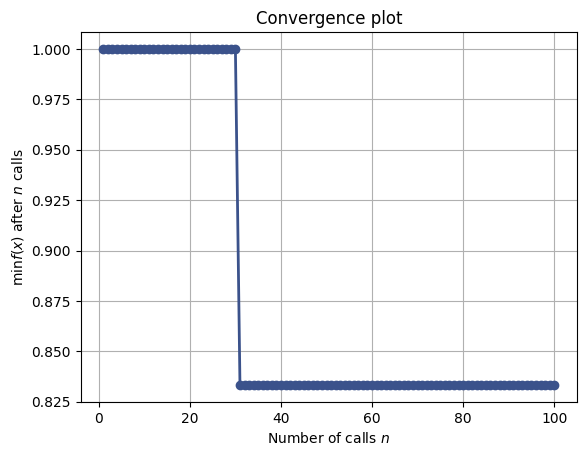

In [16]:
plot_convergence(res)

<Axes: >

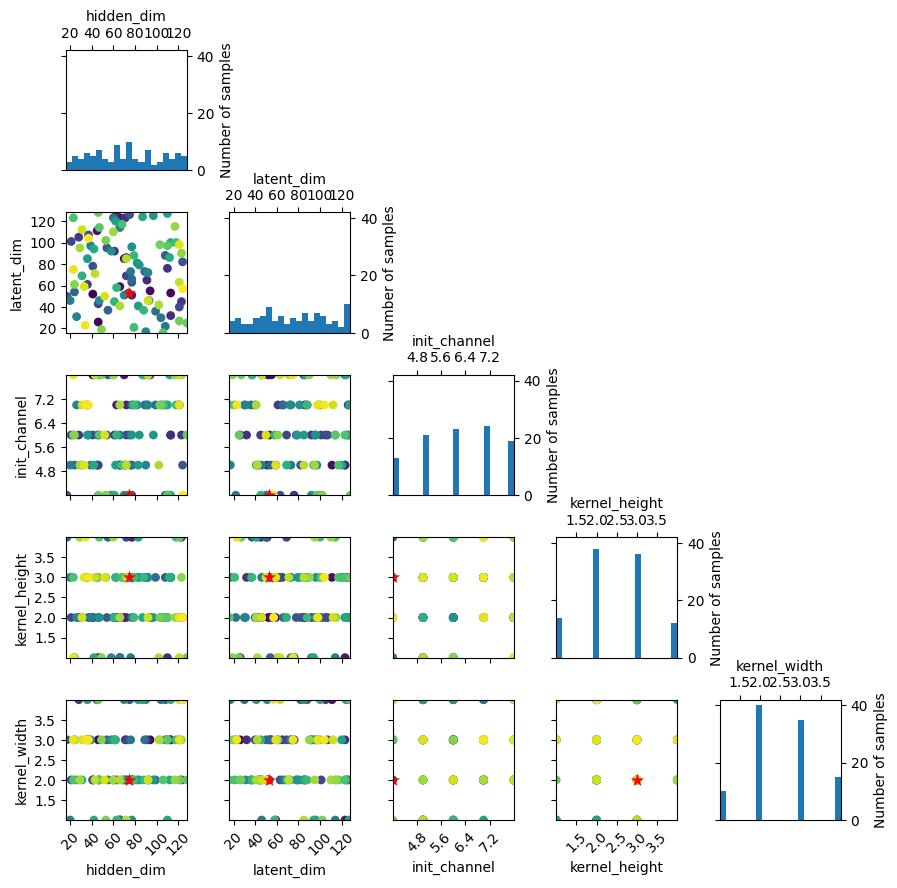

In [17]:
plot_evaluations(res)

<Axes: >

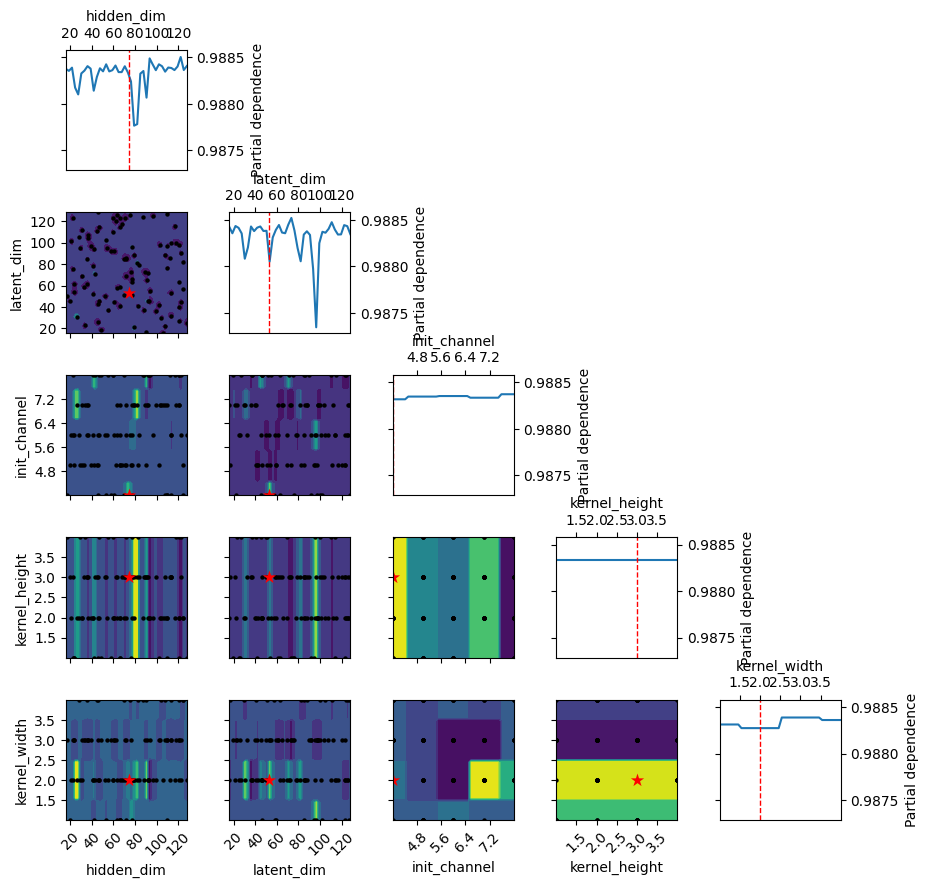

In [18]:
plot_objective(res)

<Axes: xlabel='hidden_dim', ylabel='latent_dim'>

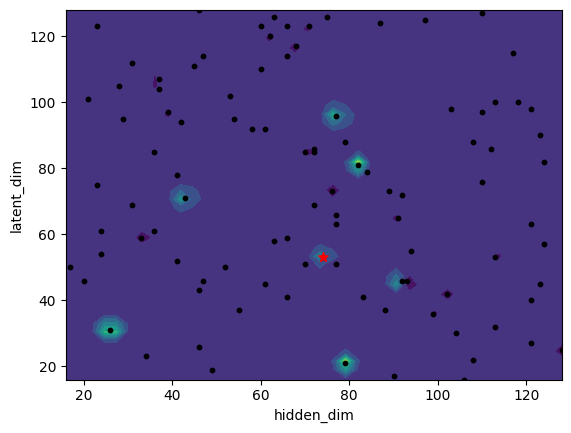

In [19]:
plot_objective_2D(res, dimension_identifier1='hidden_dim', dimension_identifier2='latent_dim')

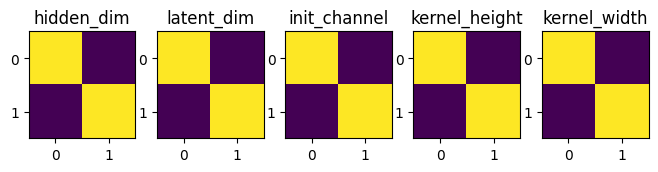

In [118]:
dim_names = [s.name for s in res.space]
x = np.array(res.x_iters)
y = np.array(res.func_vals)
df = pd.DataFrame({n:x[:, i] for i, n in enumerate(dim_names)})
df['func_vals'] = y
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 6))
for i in range(5):
    axes[i].imshow(df[[dim_names[i], 'func_vals']].corr(), cmap='viridis')
    axes[i].set_title(f'{dim_names[i]}')

#### Training Heuristics

In [20]:
best_model_name = "conv_classifier_ldim105_convblocks2_hdim28_kernel(2, 4)_idBayesOpt3ErrorPhys"
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

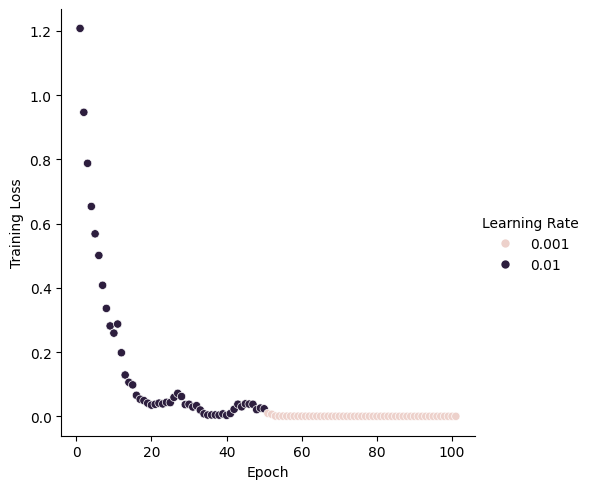

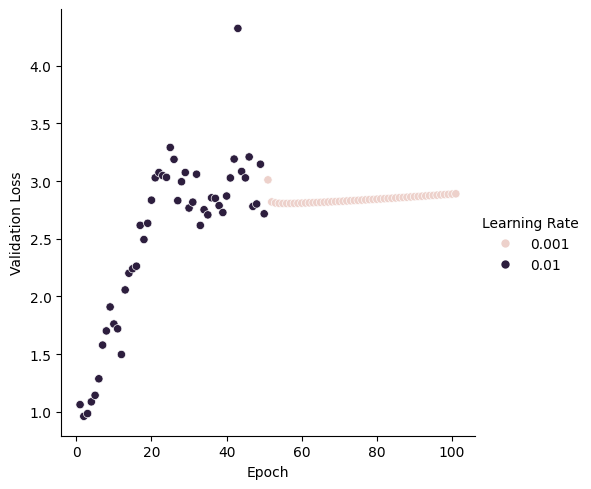

In [21]:
sns.relplot(data=best_model_loss, x='Epoch', y='Training Loss', hue='Learning Rate')
sns.relplot(data=best_model_loss, x='Epoch', y='Validation Loss', hue='Learning Rate')

In [22]:
def stopping_criterion(df, window_size):
    window_size = window_size
    sum_grad_ratios, mean_grad_ratios, var_grad_ratios = np.array([]), np.array([]), np.array([])
    for i in range(window_size, len(df)):
        loss_data = df.loc[i-window_size:i]
        past_train_loss = loss_data['Training Loss'].values
        past_val_loss = loss_data['Validation Loss'].values

        local_x = np.arange(len(past_train_loss))

        train_grad = np.gradient(past_train_loss, local_x)
        val_grad = np.gradient(past_val_loss, local_x)

        grad_ratio = -(train_grad / (val_grad + 1e-6))

        sum_grad_ratios=np.append(sum_grad_ratios, np.sum(grad_ratio))
        mean_grad_ratios=np.append(mean_grad_ratios, np.mean(grad_ratio))
        var_grad_ratios=np.append(var_grad_ratios, np.var(grad_ratio))
    return sum_grad_ratios, mean_grad_ratios, var_grad_ratios

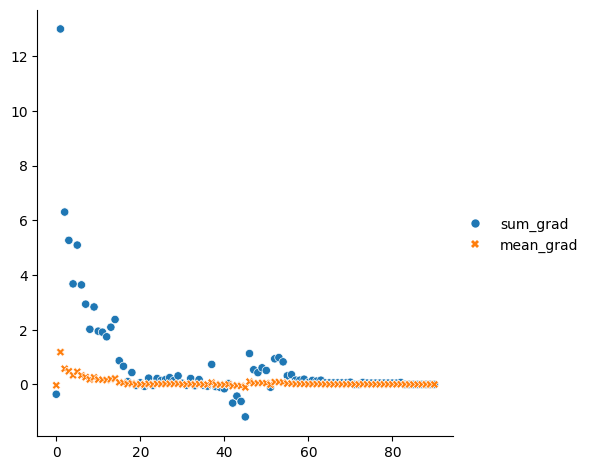

In [23]:
sum_grad_ratios, mean_grad_ratios, var_grad_ratios = stopping_criterion(df=best_model_loss, window_size=10)

sns.relplot(data={'sum_grad':sum_grad_ratios, 'mean_grad':mean_grad_ratios})#, 'var_grad':var_grad_ratios})

#### Training Statistics


In [48]:
temp_dfs = []
for f in os.listdir(save_filepath):
    if f.endswith('.csv'):
        filepath = os.path.join(save_filepath, f)

        temp_df = pd.read_csv(filepath)
        temp_df['Model Name'] = f

        temp_dfs.append(temp_df)
training_data = pd.concat(temp_dfs, ignore_index=True)

agg_training_data = training_data.groupby("Model Name").agg({
    "Epoch": ["max"],
    "Training Loss": ["last", "min"],
    "Validation Loss": ["last", "min"],
    "Accuracy": ["last", "max"],
    "Learning Rate": ["min"],
});

In [50]:
loss_overfit_scores = (agg_training_data['Validation Loss']['last'] - agg_training_data['Validation Loss']['min']) / agg_training_data['Validation Loss']['min']
loss_overfit_scores = loss_overfit_scores.sort_values(ascending=False)
loss_overfit_scores

Model Name
conv_classifier_ldim26_convblocks2_hdim46_kernel(1, 3)_idBayesOpt3ErrorPhys.csv      3.264664
conv_classifier_ldim94_convblocks2_hdim42_kernel(1, 1)_idBayesOpt3ErrorPhys.csv      3.221638
conv_classifier_ldim76_convblocks2_hdim110_kernel(1, 3)_idBayesOpt3ErrorPhys.csv     3.109918
conv_classifier_ldim45_convblocks2_hdim61_kernel(2, 3)_idBayesOpt3ErrorPhys.csv      3.049681
conv_classifier_ldim32_convblocks2_hdim113_kernel(3, 3)_idBayesOpt3ErrorPhys.csv     3.030673
                                                                                       ...   
conv_classifier_ldim53_convblocks2_hdim74_kernel(3, 2)_idBayesOpt3ErrorPhys.csv      1.082080
conv_classifier_ldim115_convblocks2_hdim117_kernel(2, 2)_idBayesOpt3ErrorPhys.csv    0.970205
conv_classifier_ldim46_convblocks2_hdim47_kernel(2, 2)_idBayesOpt3ErrorPhys.csv      0.964973
conv_classifier_ldim46_convblocks2_hdim92_kernel(2, 2)_idBayesOpt3ErrorPhys.csv      0.914651
conv_classifier_ldim128_convblocks2_hdim46_kernel

In [55]:
acc_overfit_scores = (agg_training_data['Accuracy']['last']) / (agg_training_data['Accuracy']['max'] + 1e-12)
acc_overfit_scores = acc_overfit_scores.sort_values(ascending=False)
acc_overfit_scores

Model Name
conv_classifier_ldim31_convblocks2_hdim26_kernel(2, 2)_idBayesOpt3ErrorPhys.csv     1.0
conv_classifier_ldim81_convblocks2_hdim82_kernel(3, 2)_idBayesOpt3ErrorPhys.csv     1.0
conv_classifier_ldim53_convblocks2_hdim74_kernel(3, 2)_idBayesOpt3ErrorPhys.csv     1.0
conv_classifier_ldim46_convblocks2_hdim92_kernel(2, 2)_idBayesOpt3ErrorPhys.csv     1.0
conv_classifier_ldim71_convblocks2_hdim43_kernel(3, 2)_idBayesOpt3ErrorPhys.csv     1.0
                                                                                   ... 
conv_classifier_ldim95_convblocks2_hdim54_kernel(2, 3)_idBayesOpt3ErrorPhys.csv     0.0
conv_classifier_ldim97_convblocks2_hdim110_kernel(2, 3)_idBayesOpt3ErrorPhys.csv    0.0
conv_classifier_ldim97_convblocks2_hdim39_kernel(2, 3)_idBayesOpt3ErrorPhys.csv     0.0
conv_classifier_ldim98_convblocks2_hdim103_kernel(2, 3)_idBayesOpt3ErrorPhys.csv    0.0
conv_classifier_ldim98_convblocks2_hdim121_kernel(2, 3)_idBayesOpt3ErrorPhys.csv    0.0
Length: 100, dtype: f

#### Animation creation

In [217]:
t0 = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00000/Embeddings_epoch_0/tensors.tsv"), sep='\t').values
t1 = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00050/Embeddings_epoch_50/tensors.tsv"), sep='\t').values
labels = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00050/Embeddings_epoch_50/metadata.tsv"), sep='\t').values
labels = np.array([int(s[7]) for s in labels[:, 0]])
t0.shape, t1.shape, labels

((3046, 96), (3046, 96), array([2, 0, 3, ..., 1, 3, 1]))

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

In [ ]:
tsne0 = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
t0_tsne = tsne0.fit_transform(t0)

tsne1 = TSNE(n_components=2, perplexity=30, n_iter=1200, random_state=42)
t1_tsne = tsne1.fit_transform(t1)

c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


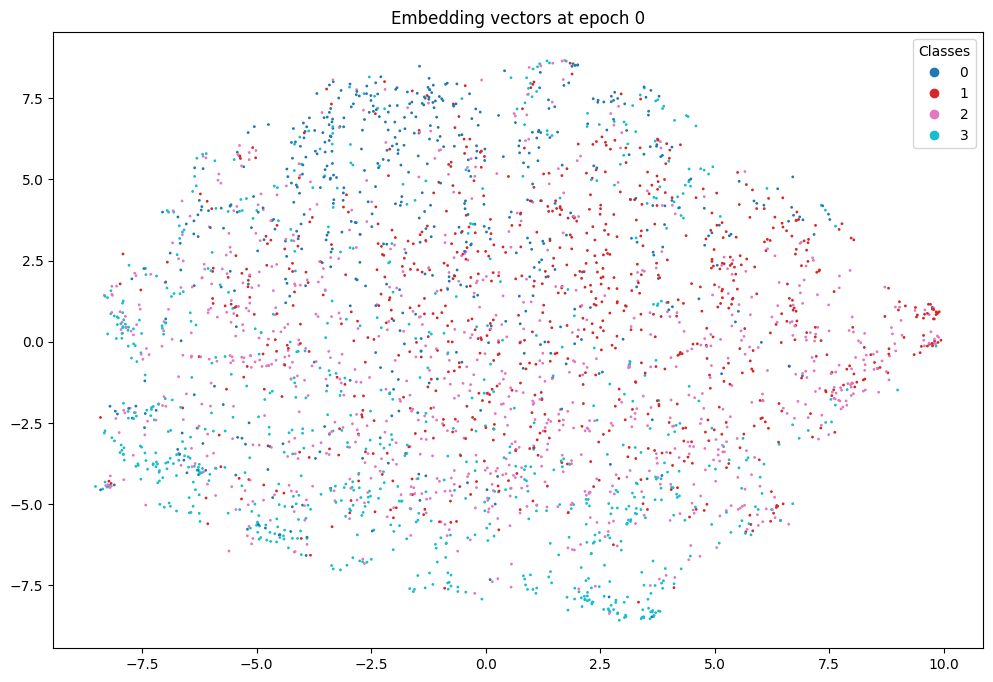

In [141]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(t0_tsne[:, 0], t0_tsne[:, 1], c=labels, cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Embedding vectors at epoch 0')
plt.show()

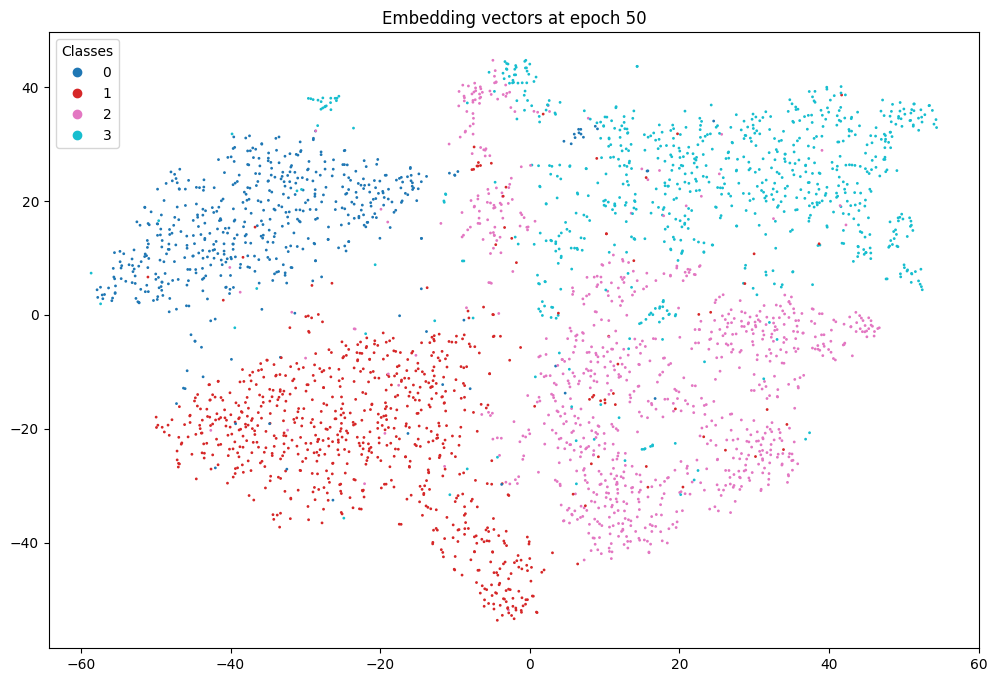

In [142]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(t1_tsne[:, 0], t1_tsne[:, 1], c=labels, cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Embedding vectors at epoch 50')
plt.show()

#### Classification head

Train classification head on encoded feature representations, backpropagate through encoder aswell

In [ ]:
# load pretrained conv_ae

conv_ae_2 = ConvAE2d()
conv_ae_2.load_state_dict(torch.load('path_to_model/conv_ae.pth'))
conv_ae_2.eval()

# freeze all layers
for param in conv_ae.parameters():
    param.requires_grad = False  

# change last fc layers
num_features = conv_ae_2.fc.in_features
conv_ae_2.fc = nn.Linear(num_features, new_num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_ae_2.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(conv_ae_2.fc.parameters(), lr=1e-3)  # only train last layer
criterion = nn.CrossEntropyLoss()
